# Forecasting the closing price, Model: SARIMAX, Stock Token: ITD, Train/Test/Validation/: 80/10/10
- Dataset: 1313 rows x 7 columns (01/03/2019 - 31/05/2024) - exogenous variable: low price
----
### Model evaluation (Test set)
- RMSE: 145.77
- MAE: 114.32
- MAPE: 1.03 %

### Import neccesary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

plt.style.use("default")

### Define the split type and stock name


In [2]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [3]:
# Choose the split_type and stock_name -> ITD - 8 1 1
split = 2
stock = 2  # ITD

## 1.Data preprocessing


In [4]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,6900,6900,6900,6900,37940,ITD
1,2019-03-04,6900,7100,6900,7100,36140,ITD
2,2019-03-05,7100,7100,6900,7100,14270,ITD
3,2019-03-06,6940,7230,6940,7170,224810,ITD
4,2019-03-07,7270,7270,7100,7170,80680,ITD
...,...,...,...,...,...,...,...
1308,2024-05-27,11300,11600,11300,11300,47400,ITD
1309,2024-05-28,11650,12050,11400,12050,322600,ITD
1310,2024-05-29,12850,12850,12450,12600,334600,ITD
1311,2024-05-30,12600,12600,12100,12500,299000,ITD


In [5]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [6]:
df.reset_index(drop=True)
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [7]:
# Shape of the dataframe
df.shape

(1313, 2)

In [8]:
df.dtypes

low      int64
close    int64
dtype: object

In [9]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,9972.168317,10160.894897
std,2917.997297,3002.802575
min,5130.000000,5320.000000
25%,7460.000000,7550.000000
50%,9900.000000,10040.000000
75%,11500.000000,11650.000000
max,20700.000000,21430.000000


## 2. Train model


In [10]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [11]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [12]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

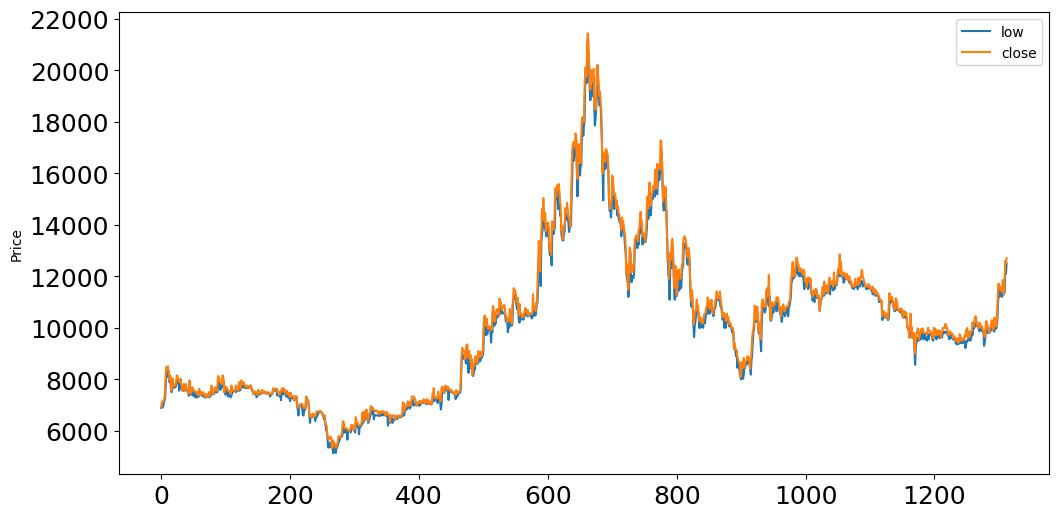

In [13]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [14]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(-1.584523707127448,
 0.4913629480785365,
 12,
 1300,
 {'1%': -3.435390199468821,
  '5%': -2.8637658312426035,
  '10%': -2.567955046745562},
 18249.61406238007)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [15]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [16]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.680
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.714
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


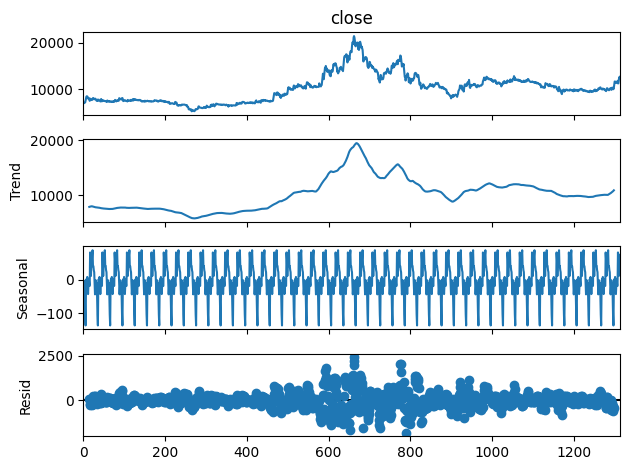

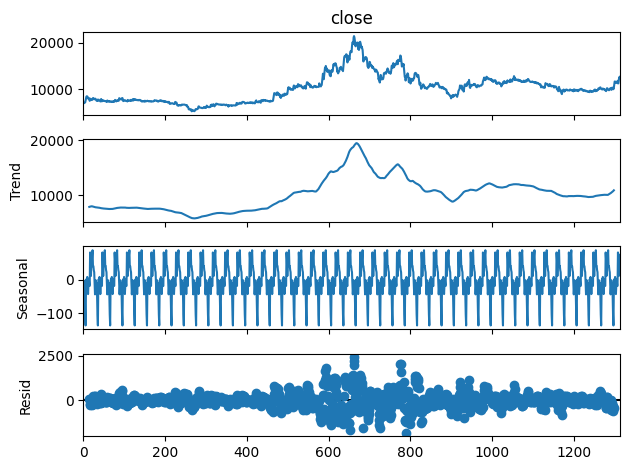

In [17]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [18]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [19]:
# Check again
adfuller(df_diff)

(-9.732329376705067,
 8.935910831610263e-17,
 11,
 1037,
 {'1%': -3.436671659540904,
  '5%': -2.8643311477003515,
  '10%': -2.5682561222519897},
 14643.868992287513)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

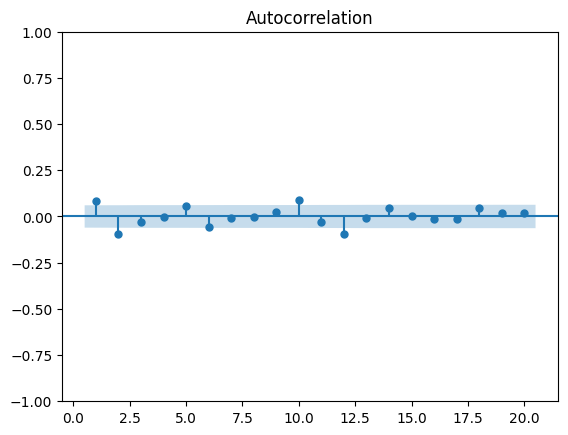

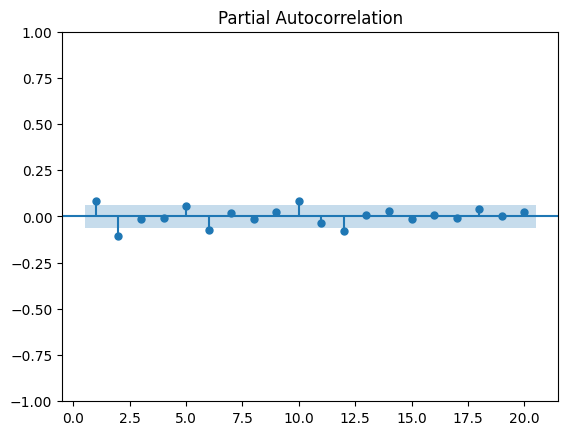

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [21]:
# Review the dataset again
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [22]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=14964.597, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=14981.157, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=14973.547, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=14972.311, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=14979.408, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=14967.925, Time=0.27 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=14967.146, Time=0.25 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=14962.534, Time=1.11 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=14961.438, Time=1.15 sec
 ARIMA(1,1,2)(2,0,0)[5] intercept   : AIC=14960.608, Time=0.63 sec
 ARIMA(1,1,2)(1,0,0)[5] intercept   : AIC=14965.503, Time=0.17 sec
 ARIMA(1,1,2)(2,0,1)[5] intercept   : AIC=14961.166, Time=0.61 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=14963.500, Time=0.50 sec
 ARIMA(0,1,2)(2,0,0)[5] intercept   : AIC=14959.563, Time=0.13 sec
 ARIMA(0,1,2)(1,0,0

In [23]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1050
Model:             SARIMAX(0, 1, 2)x(2, 0, [], 5)   Log Likelihood               -7473.877
Date:                            Mon, 03 Jun 2024   AIC                          14957.755
Time:                                    21:48:25   BIC                          14982.533
Sample:                                         0   HQIC                         14967.150
                                           - 1050                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0950      0.021      4.480      0.000       0.053       0.137
ma.L2         -0.0892      0.022   

#### Use SARIMAX to train model


In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(0, 1, 2),
    seasonal_order=(2, 0, 0, 5),
)

model_fit = model1.fit()

### Test


In [25]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([12213.79944264, 12386.22466712, 12341.9918067 , 12142.83231386,
       12266.09951939, 12460.64633835, 12140.81443263, 12241.35336247,
       12144.24952099, 11895.83966074, 11952.03090096, 12099.02058829,
       12099.39298159, 12049.64186117, 12051.12720725, 12051.28126005,
       11999.85818112, 12049.95617557, 11900.02407116, 11950.28724888,
       11850.57070464, 11850.28088356, 11700.17902634, 11750.25380796,
       11750.35718347, 11650.30972131, 11750.29220831, 11750.2974462 ,
       11800.35390317, 11750.33217626, 11800.39909757, 11650.24648512,
       11850.41877417, 11800.3791296 , 11750.34416087, 12000.56121934,
       11850.42554131, 11950.51118266, 11950.51221705, 11750.34364649,
       11850.43056489, 11900.47110221, 11850.42865444, 11750.34371812,
       11650.25911323, 11750.34467364, 11650.25886688, 11750.34409277,
       11700.30157835, 11700.30172864, 11700.30185806, 11650.25909637,
       11600.21651371, 11650.25912863, 11450.08879783, 11450.08882953,
      

#### Validate


In [26]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([ 9961.88270859,  9844.06088735,  9689.73431993,  9700.75372227,
        9904.08907834,  9778.36329512,  9718.75287867,  9639.13846979,
        9742.20500466,  9844.09330304,  9700.11416691,  9897.14644833,
        9897.51884163,  9947.85290939,  9849.25306729,  9899.44971418,
        9697.89885298,  9647.91165925,  9848.27771347,  9858.50681592,
        9858.87545986,  9848.57711996,  9698.47526274,  9758.55856318,
        9848.73860805,  9848.77633407,  9848.67363289,  9748.5936826 ,
        9948.77792184,  9778.65396912,  9778.67829633,  9778.65346615,
       10008.85131166,  9998.84574236,  9948.81077363,  9948.81486165,
        9998.84955998,  9998.85001315,  9998.85104753,  9898.76766516,
        9848.72680129,  9858.73326333,  9698.59710857,  9768.65699215,
        9918.78535771,  9938.80276758,  9748.64029146,  9828.70847972,
        9698.59781475,  9698.59796503,  9728.62365091,  9748.64052094,
        9548.47015602,  9548.47017685,  9498.42762832,  9528.45321647,
      

### Predict the next 30/60/90 days


In [27]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [28]:
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [29]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[15236.11526439 15214.98917576 15227.41797267 15235.04791945
 15264.84900004 15265.84450589 15252.88722796 15259.96003286
 15269.56044281 15277.98261625 15290.75032563 15294.23129394
 15301.22275049 15308.13328741 15316.23769673 15323.01081278
 15328.24939119 15334.92385479 15341.7385959  15348.57824278
 15355.56594997 15361.89519214 15368.54018043 15375.19143121
 15381.91386997 15388.57065923 15395.0870213  15401.71132244
 15408.34424857 15414.98417899]


### Plotting the data


In [30]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(16, 9))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Forecasting Using SARIMAX")
    plt.legend()
    plt.show()

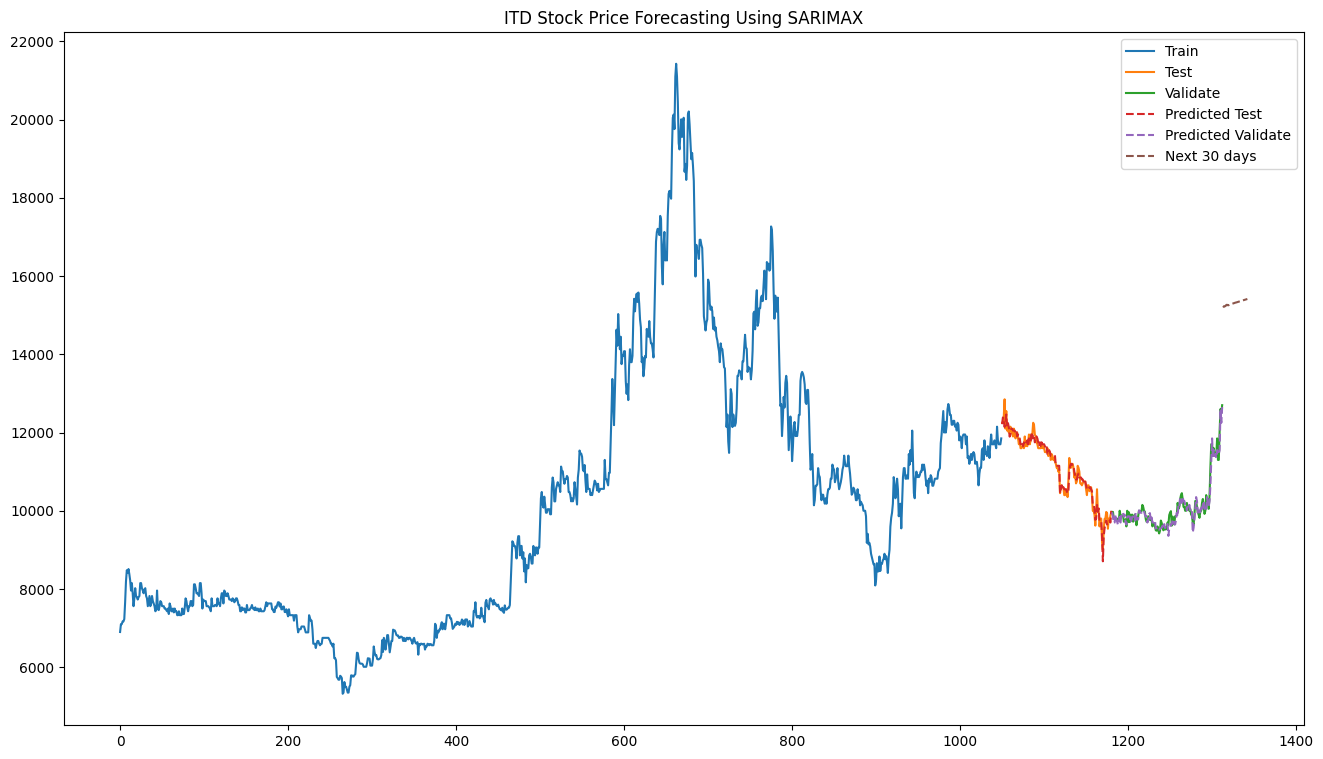

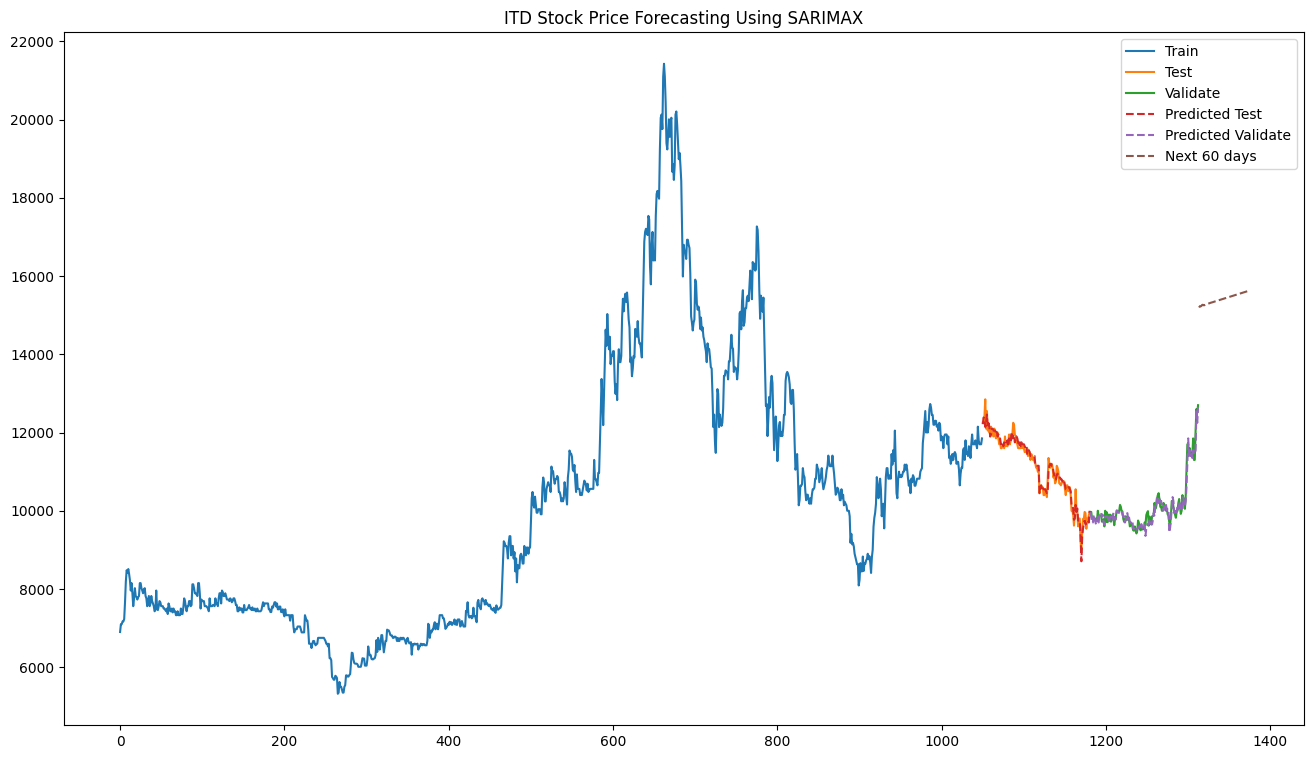

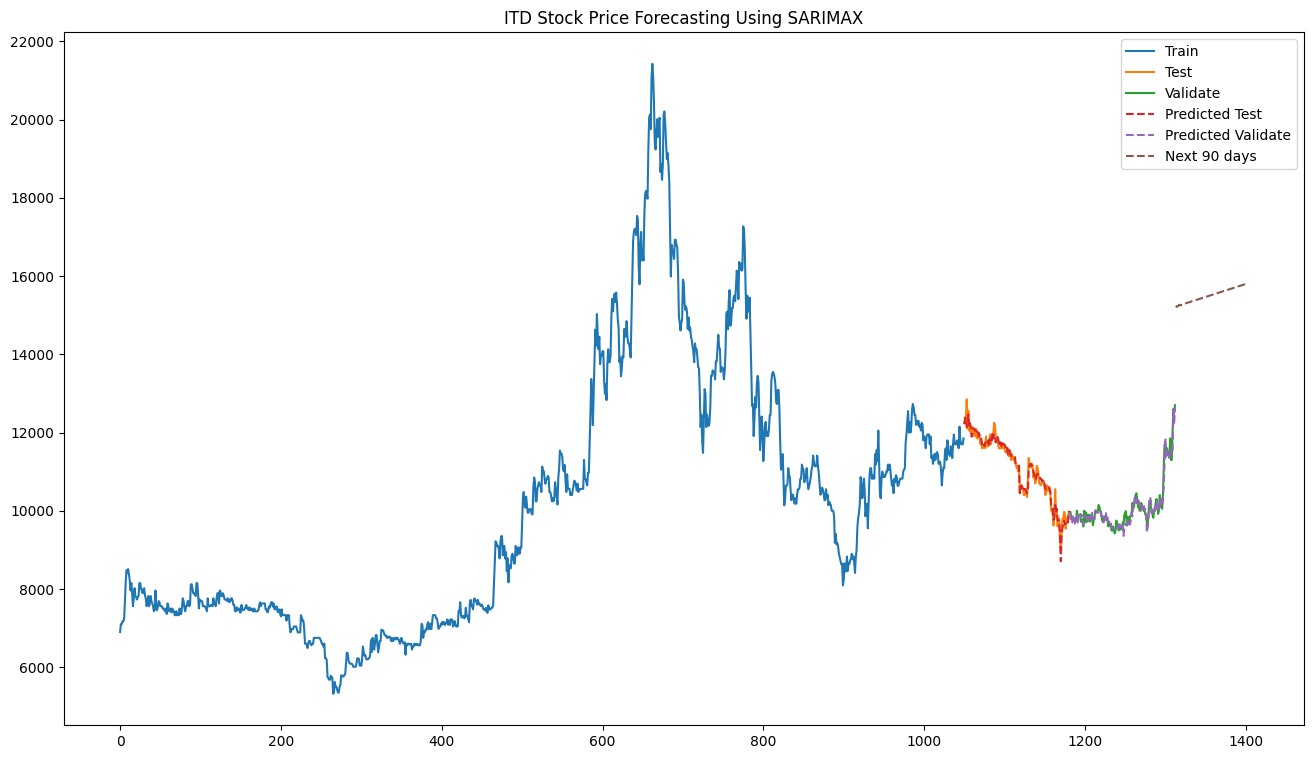

In [31]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [32]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 145.77505907788142
MAE on test data: 114.32281953143467
MAPE on test data: 1.0343566838380673 %


In [33]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 152.02354743062216
MAE on validation data: 117.98414229159297
MAPE on validation data: 1.157534106052999 %
